In [112]:
#1.0
#necessary libraries
import soundfile as sf
import IPython
import numpy as np
import matplotlib.pyplot as plt
import librosa
import math
import scipy as sp
from scipy.io import wavfile

N = 512
stereo, samplerate = sf.read('music_dsp2024.wav')
mono = (stereo[:, 0] + stereo[:, 1]) # Μετατροπή stereo -> mono (θέλουμε τον μέσο όρο)
mono = mono/np.max(mono) # Κανονικοποίηση σε τιμές [-1, 1]
mono = mono[0:len(mono) // N * N] #slicing
#IPython.display.Audio(mono,rate=samplerate) #Ακρόαση σήματος
num_samples = len(mono)
windowed_frames = len(mono) // N 

print(f'Number of samples: {num_samples}')
print(f'Number of windows: {num_samples//N}')


Number of samples: 724992
Number of windows: 1416


In [29]:
print(f"{windowed_frames}")

1416


Text(0, 0.5, 'Amplitude')

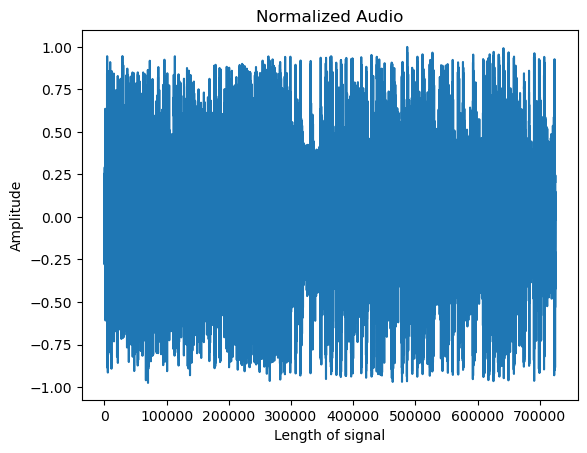

In [16]:
plt.plot(mono)
plt.title('Normalized Audio')
plt.xlabel('Length of signal')
plt.ylabel('Amplitude')

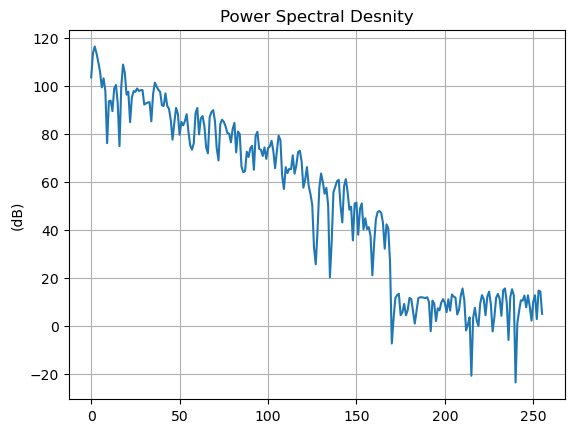

In [17]:
#1.1
def bark(f):
    return 13 * np.arctan(.00076*f) + 3.5*np.arctan((f/7500) * 2)

#Calculate DFT
N = 512
w = np.hanning(N)

P = []
for i in range(0, len(mono) // N):
  PN = 90.302 # dB
  DFT = np.fft.fft(mono[N*i:N*(i+1)]*w, 512)  #selects a segment of length N from mono and applies a window function w
  P2 = 10 * np.log10( np.abs(DFT) **2 )[0 : N//2] #final one-sided calculation of each sample (we work only with the first 256 samples)

  P_k = PN + P2
  P.append(P_k)

plt.figure()
plt.plot(P[99]) #e.g.
plt.ylabel('(dB)')
plt.title('Power Spectral Desnity')
plt.grid()

Text(0.5, 0, 'Δείκτης i')

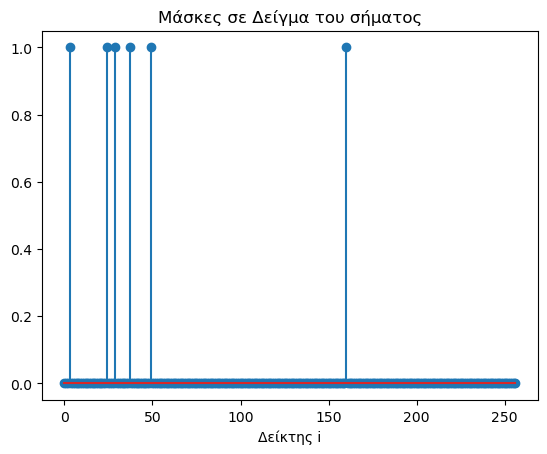

In [18]:
#1.2

Delta = np.zeros(257, dtype = int) # Delta initialization
for i in range (2, 63, 1): # Delta values
  Delta[i] = 2
for i in range (63, 127, 1):
  Delta[i]  = 3
for i in range (127, 250, 1):
  Delta[i]  = 6

def mask_finder(P_w): # Αυτή η συνάρτηση δέχεται ως όρισμα ένα φάσμα P(k), μήκους 256 και επιστρέφει 1 ή 0 σε έναν πίνακα(msk[0:256] αν σε κάθε δείκτη έχουμε μάσκα ή όχι αντίστοιχα)
  S_T = np.zeros(257, dtype = bool)

  for k in  range(2, 250, 1):
    flag_1 = P_w[k] > P_w[k-1] and P_w[k] > P_w[k+1]
    flag_2 = 1
    for delta in range(2, Delta[k]+1, 1):
      flag_2 = flag_2 * (P_w[k] > P_w[k-delta] + 7) * (P_w[k] > P_w[k+delta] + 7) #condition

    if  flag_1 and flag_2:
      S_T[k] = 1 #we found a mask!

  return S_T

S_T = [] # Αυτή η λίστα περιέχει τα S_T για το κάθε παραθυροποιημένο σήμα
for P_w in P:
  S_T.append(mask_finder(P_w))

plt.stem(S_T[0]) #example showing masks
plt.title("Μάσκες σε Δείγμα του σήματος")
plt.xlabel("Δείκτης i")


Text(0, 0.5, 'PTM(dB)')

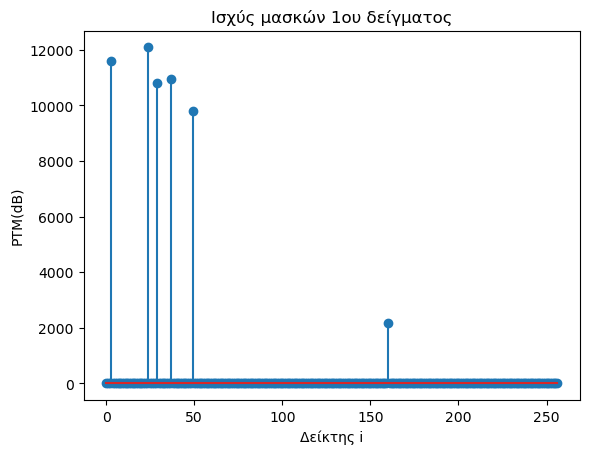

In [19]:
P_TM = [] # Αυτή η λίστα περιέχει τα P_TM για κάθε παραθυροποιημένο σήμα

for i in range(0, len(P), 1):
  P_TM_k = np.zeros(257)
  for k in range(0, 257, 1):
    if S_T[i][k] == 1:
      P_TM_k[k] = 10*np.log10( 10**(0.1*P[i][k-1]) + 10**(0.1*P[i][k]) + 10**(0.1*P[i][k+1]) )
      P_TM_k[k]=P_TM_k[k]**2
  P_TM.append(P_TM_k)

plt.stem(P_TM[0]) #Απεικόνιση ισχύος μασκών για το 1ο παράθυρο
plt.title("Ισχύς μασκών 1ου δείγματος")
plt.xlabel('Δείκτης i')
plt.ylabel('PTM(dB)')

Text(0, 0.5, 'PNM(dB)')

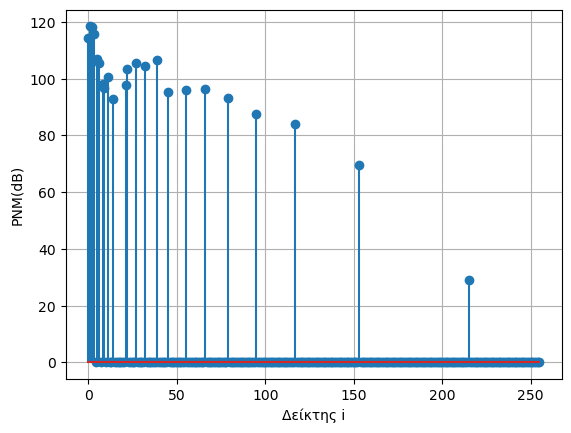

In [20]:
P_NM = np.load('P_NM-24.npy')
#P_NM = np.square(P_NM)
P_NM = P_NM.transpose()
P_NM = P_NM[0:1416, 0:256]

plt.stem(P_NM[99])
plt.grid()
plt.xlabel('Δείκτης i')
plt.ylabel('PNM(dB)')

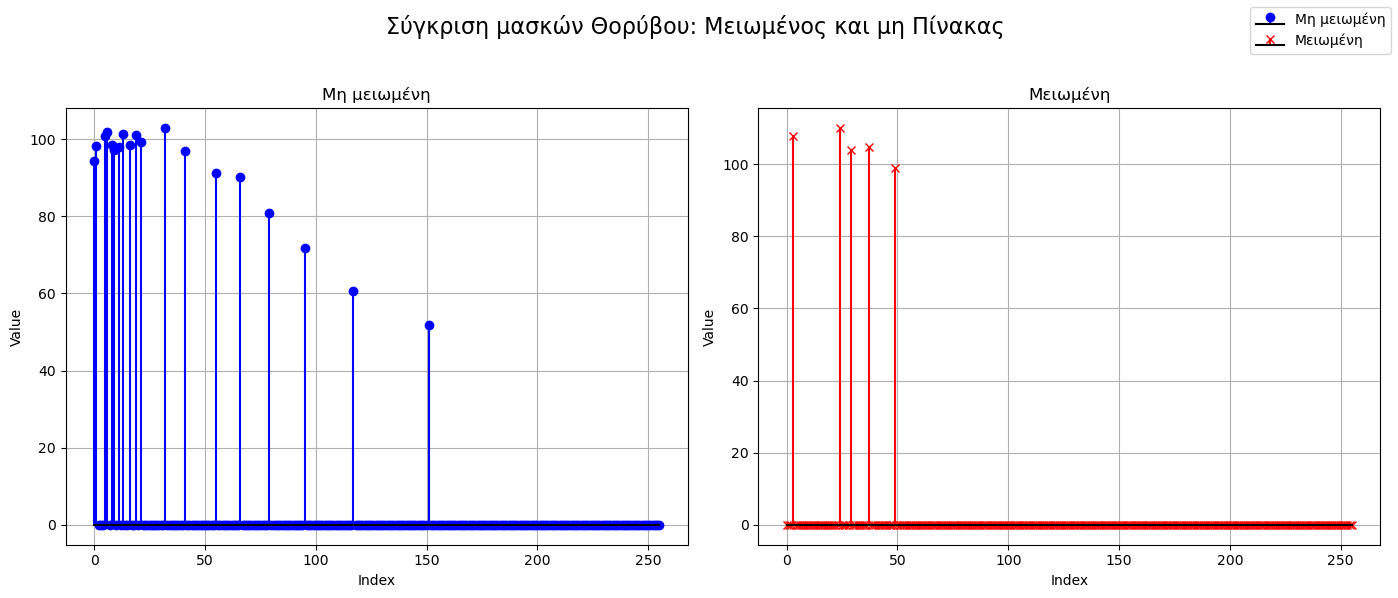

In [36]:
#1.3

P_TMc = np.load('P_TMc-24.npy') #load files
#P_TMc = P_TMc.transpose()
#P_TMc = P_TMc[0:1416, 0:256]

P_NMc = np.load('P_NMc-24.npy')
#P_NMc = P_NMc.transpose()
#P_NMc = P_NMc[0:1416, 0:256]

# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the non-reduced noise mask on the first subplot
axes[0].stem(P_NMc[:,0], 'b', markerfmt='bo', basefmt='k')
axes[0].set_title('Μη μειωμένη')
axes[0].grid()
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Value')

# Plot the reduced noise mask on the second subplot
axes[1].stem(P_TMc[:,0], 'rx', markerfmt='rx', basefmt='k')
axes[1].set_title('Μειωμένη')
axes[1].grid()
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Value')

fig.suptitle('Σύγκριση μασκών Θορύβου: Μειωμένος και μη Πίνακας', fontsize=16)
fig.legend(['Μη μειωμένη', 'Μειωμένη'], loc='upper right')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


In [40]:
#1.4
def SF(i, j, P_TM):
  Delta_b = bark(i) - bark(j)
  if Delta_b >= -3 and Delta_b < -1:
    return 17* Delta_b - 0.4 *  P_TM + 11
  elif Delta_b >= -1 and Delta_b < 0:
    return ( 0.4 * P_TM + 6 ) * Delta_b
  elif Delta_b >= 0 and Delta_b < 1:
    return - 17 * Delta_b
  elif Delta_b >= 1 and Delta_b < 8:
    return (0.15*P_TM - 17) * Delta_b - 0.15 * P_TM
  else: return 0 

def threshold_TM(P_TMc): # Αυτή η συνάρτηση υπολογίζει για ένα δείγμα μήκους Ν = 512 το κατώφλι κάλυψης σε κάθε
                         # συχνότητα(i) που προέρχεται από τις γειτονικές μάσκες(j)
  
  T_TM = np.zeros((windowed_frames+1, 256, 256)) # Αρχικοποίηση του πίνακα που επιστρέφει η συνάρτηση
  for k in range(windowed_frames+1):
    for j in range(0, 256):
        if P_TMc[j, k] > 0:
          for i in range(0, 256):
              T_TM[k, j, i] = P_TMc[j, k] - 0.275 * bark(j) + SF(i, j, P_TMc[j, k]) - 6.025 # (dB SPL)   

  return T_TM    

def threshold_NM(P_NMc): # Αυτή η συνάρτηση υπολογίζει για ένα δείγμα μήκους Ν = 512 το κατώφλι κάλυψης 
                         # θορύβου σε κάθε συχνότητα(i) που προέρχεται από τις γειτονικές μάσκες(j)
  
  T_NM = np.zeros((windowed_frames+1, 256, 256)) # Αρχικοποίηση του πίνακα που επιστρέφει η συνάρτηση
  for k in range(windowed_frames+1):
    for j in range(0, 256):
      if P_NMc[j, k] > 0:
        for i in range(0, 256):
          T_NM[k, j, i] = P_NMc[j, k] - 0.175 * bark(j) + SF(i, j, P_NMc[j, k]) - 2.025 # (dB SPL)   

  return T_NM    

T_TM_list = np.zeros((windowed_frames+1, 256, 256)) 
T_TM_list = threshold_TM(P_TMc)

T_NM_list = np.zeros((windowed_frames+1, 256, 256))
T_NM_list = threshold_NM(P_NMc)


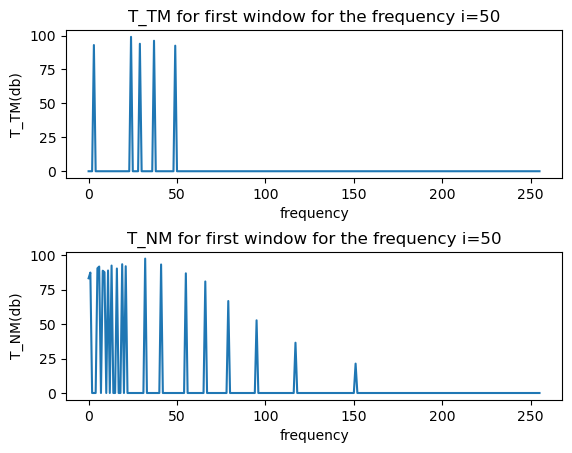

In [41]:
plt.subplot(2,1,1)
plt.plot(T_TM_list[0,:, 50])
plt.xlabel('frequency')
plt.ylabel('T_TM(db)')
plt.title('T_TM for first window for the frequency i=50')

plt.subplot(2,1,2)
plt.plot(T_NM_list[0,:, 50])
plt.xlabel('frequency')
plt.ylabel('T_NM(db)')
plt.title('T_NM for first window for the frequency i=50')

plt.subplots_adjust(hspace=0.5)

C:\Users\nikol\AppData\Local\Temp\ipykernel_6100\780941069.py:14: RuntimeWarning: overflow encountered in scalar power
  TG[k, i] = 10*np.log10(10**(0.1*TQ[i]) + sum_T_TM[k, i] + sum_T_NM[k, i]+0.001)


Text(0.5, 1.0, 'Global Masking Threshold for first window')

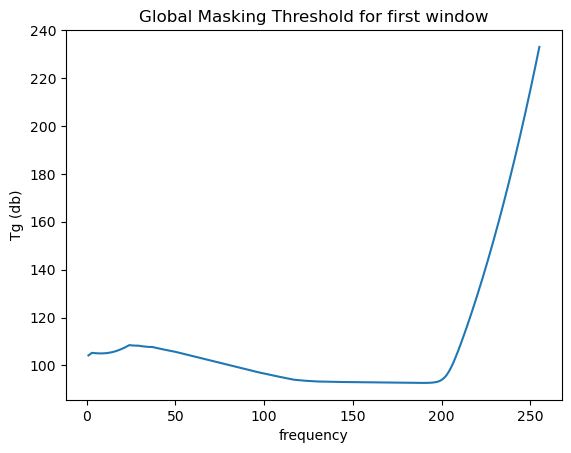

In [47]:
#1.5
TG = np.zeros((windowed_frames+1, N//2), dtype = 'double')
sum_T_TM = np.zeros((windowed_frames+1, N//2))
sum_T_NM = np.zeros((windowed_frames+1, N//2))
TQ = np.zeros(N//2)

for k in range(windowed_frames+1):
    for i in range(N//2):
        for j in range(N//2):
          sum_T_TM[k ,i] += 10**(0.1*T_TM_list[k, j, i])  
          sum_T_NM[k, i] += 10**(0.1*T_TM_list[k, j, i])
        f = i*44100/N
        TQ[i] = 3.64*((f+.0000000001)/1000)**(-0.8) - 6.5*np.exp(-0.6*(f/(1000-3.3))**2) + 0.001*(f/1000)**4
        TG[k, i] = 10*np.log10(10**(0.1*TQ[i]) + sum_T_TM[k, i] + sum_T_NM[k, i]+0.001)
        
plt.plot(TG[0, :])
plt.xlabel('frequency')
plt.ylabel('Tg (db)')
plt.title('Global Masking Threshold for first window') 

In [68]:
#2.0
import numpy as np

def compute_analysis_filters():
    M = 32
    L = 2 * M
    h = np.zeros((M, L))
    for k in range(M):
        for n in range(L):
            h[k, n] = (np.sin((n + 0.5) * np.pi / (2 * M)) *
                       np.sqrt(2 / M) *
                       np.cos(((2 * n + M + 1) * (2 * k + 1) * np.pi) / (4 * M)))
    return h

def compute_synthesis_filters(h):
    M, L = h.shape
    g = np.zeros_like(h)
    for k in range(M):
        for n in range(L):
            g[k, n] = h[k, 2 * M - 1 - n]
    return g
    
def signal_slicing():
    N = 512
    signal = mono
    segment = np.zeros((windowed_frames+1, N)) # To keep the segments (1416) of the signal
    
    for n in range(windowed_frames):
        segment[n] = signal[(n * N):(n * N + N)] * np.hanning(N)
        
    # Pad the segment with zeros if it's shorter than segment length, N
    extra_len = len(mono) - windowed_frames * N
    for i in range(extra_len):
        segment[windowed_frames, i] = mono[i + windowed_frames * N] * np.hanning(N)[i]
    
    return segment

In [69]:
h_k = compute_analysis_filters()
g_k = compute_synthesis_filters(h_k)
x = signal_slicing()

In [78]:
#2.1
from scipy.signal import convolve

def analysis_with_filter(x, analysis_filters):
    M = 32
    L = 2 * M

    num_of_segments = len(x) # 1416
    segment_length = N # Length of each segment, N = 512
    filter_length = len(analysis_filters[0]) # Length of the filter h_k, 64
    convolved_length = segment_length + filter_length - 1 # Length of the convolution, 512+64-1
    
    v = np.zeros((windowed_frames+1, 32, N + L - 1)) # For filtered signals
    for i in range(windowed_frames+1): # For all the segments
        for m in range (M): # For all the filters h_k
            v[i, m] = convolve(x[i], analysis_filters[m], mode='full')
    
    # Decimation by factor M
    decimated_length = (convolved_length + M - 1) // M # Length after decimation 

    y = np.zeros((windowed_frames+1, 32, (N + L - 1) // M))
    
    for i in range(windowed_frames+1):
        for m in range(M):
            for n in range((N + L - 1) // M):
                y[i, m, n] = v[i, m, n * M]
    
    return y

signal_y = analysis_with_filter(x ,h_k)

In [88]:
#2.2   
B = 16
R = 2 ** B
M = 32
L = 2 * M
sumBk = 0

Bk = np.zeros((windowed_frames+1, M))
for j in range(windowed_frames+1):
    for k in range(M):
        TGmin = TG[j, 1]
        for i in range(1, N // 2):
            if (k * N // M <= i <= (k + 1) * N // M and TG[j,i] < TGmin):
                TGmin = TG[j,i]
        Bk[j,k] = int(np.log2(R / TGmin) - 1)
        sumBk += Bk[j, k] * (N + L - 1) // M
D = np.zeros((windowed_frames+1, M))
for j in range(windowed_frames+1):
    min = np.min(x[j])
    max = np.max(x[j])
    for k in range(M):
        D[j,k] = (max - min) / (2**Bk[j, k])
        
def adaptive_quantizer(signal, num_bits, steps):
    num_levels = 2 ** num_bits   
    min_level = -((num_levels // 2) - 1) * steps
    max_level = (num_levels // 2) * steps
    signal_clipped = np.clip(signal, min_level, max_level) 
    quantized_signal = steps * np.round(signal_clipped / steps)
    return quantized_signal

def non_adaptive_quantizer(signal, B_k=8, steps=0.2):
    num_levels = 2 ** B_k   
    min_level = -((num_levels // 2) - 1) * steps
    max_level = (num_levels // 2) * steps
    signal_clipped = np.clip(signal, min_level, max_level) 
    quantized_signal = steps * np.round(signal_clipped / steps)
    return quantized_signal



C:\Users\nikol\AppData\Local\Temp\ipykernel_6100\4109027883.py:29: RuntimeWarning: invalid value encountered in divide
  quantized_signal = steps * np.round(signal_clipped / steps)


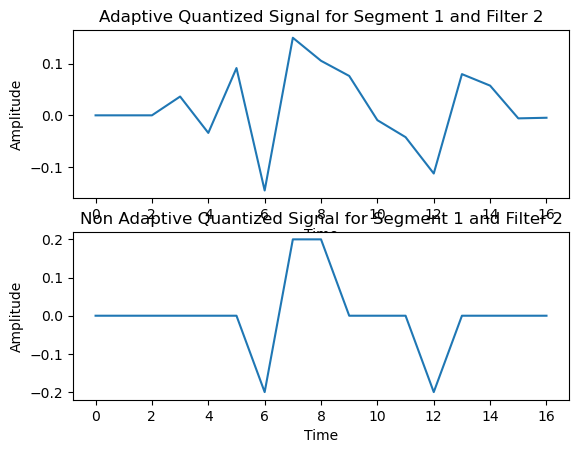

<Figure size 640x480 with 0 Axes>

In [89]:
x_adaptive = np.empty_like(signal_y)
for j in range (windowed_frames+1):
    for k in range(M):
        x_adaptive[j, k] = adaptive_quantizer(signal_y[j, k], Bk[j, k], D[j, k])
plt.subplot(2,1,1)
plt.plot(x_adaptive[0,1])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Adaptive Quantized Signal for Segment 1 and Filter 2')

x_non_adaptive = np.empty_like(signal_y)
for j in range (windowed_frames+1):
    for k in range(M):
        x_non_adaptive[j, k] = non_adaptive_quantizer(signal_y[j, k])
plt.subplot(2,1,2)
plt.plot(x_non_adaptive[0,1])
plt.title("Non Adaptive Quantized Signal for Segment 1 and Filter 2")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

plt.subplots_adjust(hspace=0.5)

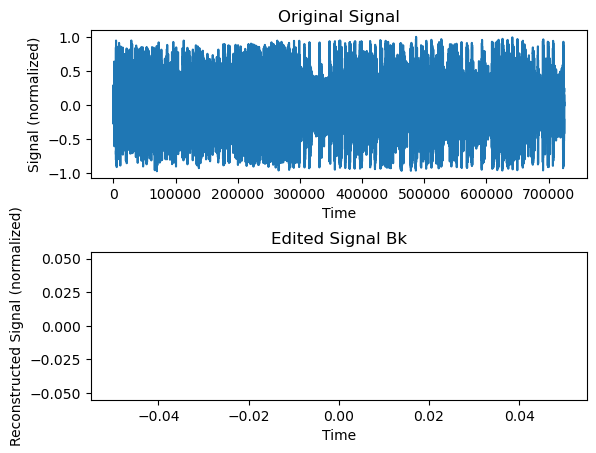

In [114]:
#2.3
w = np.empty((windowed_frames+1, 32, N + L - 1))
afterw = np.zeros((windowed_frames+1, 32, N + 2 * L - 2))

res = np.zeros((windowed_frames+1, N + 2 * L - 2))
for i in range(windowed_frames+1):
    for k in range(M):
        for n in range((N + L - 1) // M):
            w[i, k, M * n] = x_adaptive[i, k, n]
        afterw[i, k] = np.convolve(w[i, k], g_k[k])
        res[i] += afterw[i, k]
        
res_nodelay = np.empty_like(x)
for i in range(windowed_frames+1):
    for j in range(N + 2 * L - 2):
        if (j >= 0) and (j <= 94) and  (i > 0):
            res_nodelay[i, j] = res[i, j + 32] + res[i - 1, j + 511 + 32]
        elif (j >= 0) and (j < 512):
           res_nodelay[i, j] = res[i, j + 32]
      

finlen = (windowed_frames+1) * (N)
reconst = np.zeros(finlen)
for i in range(windowed_frames+1):
    reconst[i*N:N*(i + 1)] = res_nodelay[i]
reconst /= np.max(np.abs(reconst))
output_file_path = 'output_audio.wav'
rate = 44100
sf.write(output_file_path, reconst, rate)
sf.write('Music_reconstructed.wav', mono, rate)

plt.subplot(2,1,1)
plt.plot(mono)
plt.title('Original Signal')
plt.xlabel('Time')
plt.ylabel('Signal (normalized)')

plt.subplot(2,1,2)
plt.plot(reconst)
plt.title('Edited Signal Bk')
plt.xlabel('Time')
plt.ylabel('Reconstructed Signal (normalized)')
plt.subplots_adjust(hspace=0.5)



Text(0, 0.5, 'final signal(normalized)')

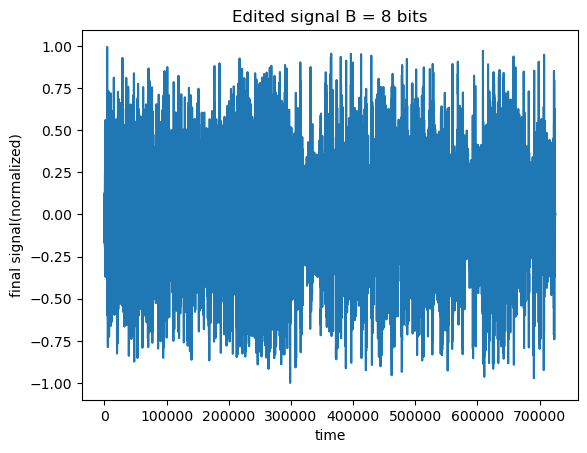

In [109]:
wb = np.empty((windowed_frames+1, 32, N + L - 1))
afterwb = np.zeros((windowed_frames+1, 32, N + 2 * L - 2))
resb = np.zeros((windowed_frames+1, N + 2 * L - 2))
for i in range(windowed_frames+1):
    for k in range(M):
        for n in range((N + L - 1) // M):
            wb[i,k,M*n] = x_non_adaptive[i, k, n]
        afterwb[i,k] = np.convolve(wb[i,k], g_k[k])
        resb[i] += afterwb[i, k]
        
reconstb = np.zeros(finlen)
resb_nodelay = np.empty_like(x)
for i in range(windowed_frames+1):
    for j in range(N + 2 * L - 2):
        if (j >= 0) and (j <= 94) and  (i > 0):
            resb_nodelay[i, j] = resb[i, j + 32] + resb[i - 1, j + 511 + 32]
        elif (j >= 0) and (j < 512):
           resb_nodelay[i, j] = resb[i, j + 32]
for i in range(windowed_frames+1):
    reconstb[i*N:N*(i+1)] = resb_nodelay[i]
reconstb /= np.max(np.abs(reconstb))



output_file_path = 'output_audio_b.wav'
rate = 44100
sf.write(output_file_path, reconst, rate)
plt.plot(reconstb)
plt.title('Edited signal B = 8 bits')
plt.xlabel('time')
plt.ylabel('final signal(normalized)')

In [111]:
sum = 0
sumb = 0
for i in range(windowed_frames * N):
    sum += (mono[i] - reconst[i])**2
    sumb += (mono[i] - reconstb[i])**2
MSE = sum/(windowed_frames * N)
MSEb = sumb/(windowed_frames * N)
print(MSE)
print(MSEb)

nan
0.07447135677702141
